In [1]:
# 01 — Exploratory Analysis: Waveform, Envelope, and Spectrograms

"""
This notebook is the starting point of the project.

Goals:
1. Load a small set of instrument clips (≈5 s each), ideally playing the same note and intensity.
2. Standardize the audio (mono, 22.05 kHz, equalized RMS, fixed duration).
3. Visualize waveform + amplitude envelope and mel-spectrogram for each instrument.
4. Extract a compact feature summary (temporal, spectral, perceptual) to a CSV for later stages.

Tip:
Keep the dataset controlled: same note, similar loudness, no effects — 
this reduces non-timbral confounders and highlights the features related to timbre.
"""


'\nThis notebook is the starting point of the project.\n\nGoals:\n1. Load a small set of instrument clips (≈5 s each), ideally playing the same note and intensity.\n2. Standardize the audio (mono, 22.05 kHz, equalized RMS, fixed duration).\n3. Visualize waveform + amplitude envelope and mel-spectrogram for each instrument.\n4. Extract a compact feature summary (temporal, spectral, perceptual) to a CSV for later stages.\n\nTip:\nKeep the dataset controlled: same note, similar loudness, no effects — \nthis reduces non-timbral confounders and highlights the features related to timbre.\n'

In [20]:
import utils
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import librosa

In [ ]:
# Plot settings
plt.rcParams["figure.figsize"] = (10, 3)
plt.rcParams["figure.dpi"] = 120

# Project paths
REPO = Path("..").resolve()
DATA = (REPO / "data/00_single_sample").resolve()
OUTP = (REPO / "output").resolve()
PLOTS = OUTP / "plots"
PLOTS.mkdir(parents=True, exist_ok=True)

# Audio configuration
SR = 22050
TARGET_DUR = 5.0
N_MFCC = 13
ROLLOFF_PCT = 0.85

# Map your audio files here
AUDIO_PATHS = {
    "bass": DATA / "bass.wav",
    "piano":  DATA / "piano.wav",
    "flute":  DATA / "flute.wav",
    "drums":  DATA / "drums.wav",
    "trumpet": DATA / "trumpet.wav",
}


In [15]:
waves = {}
for name, path in AUDIO_PATHS.items():
    if not Path(path).exists():
        print(f"[WARN] Missing file: {path}")
        continue
    y = utils.load_pad_mono(path)
    y = utils.match_rms(y)
    waves[name] = y

list(waves.keys())


['guitar', 'piano', 'flute', 'drums', 'trumpet']

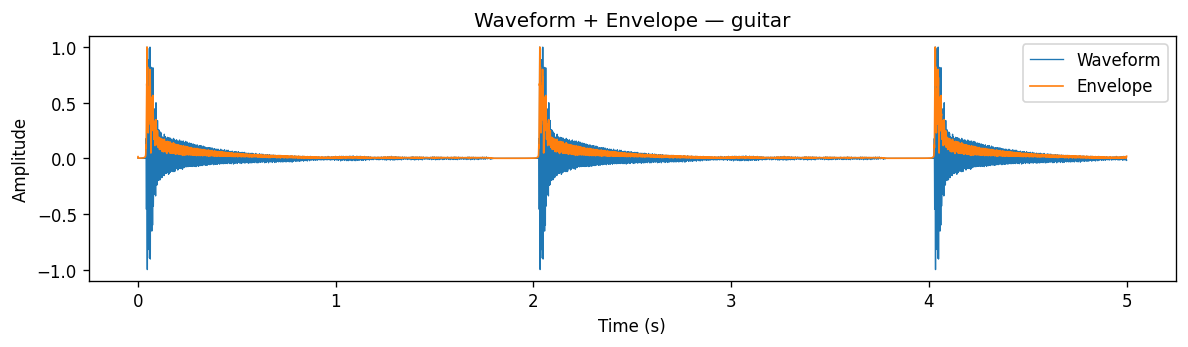

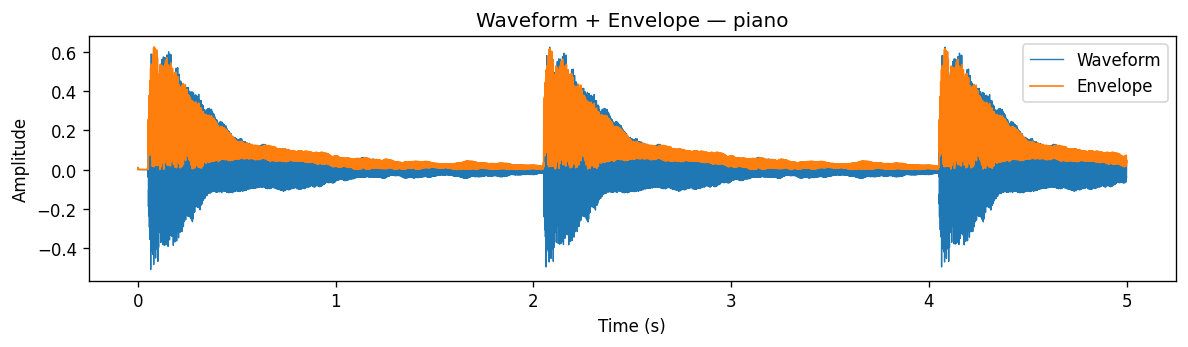

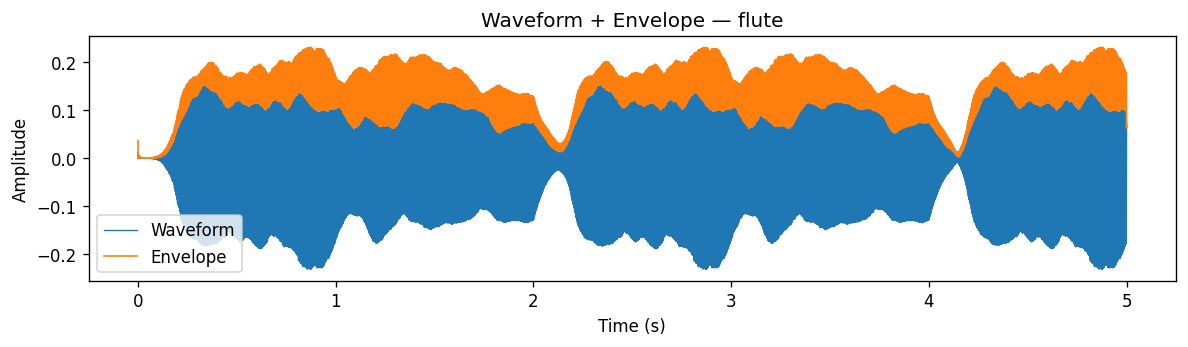

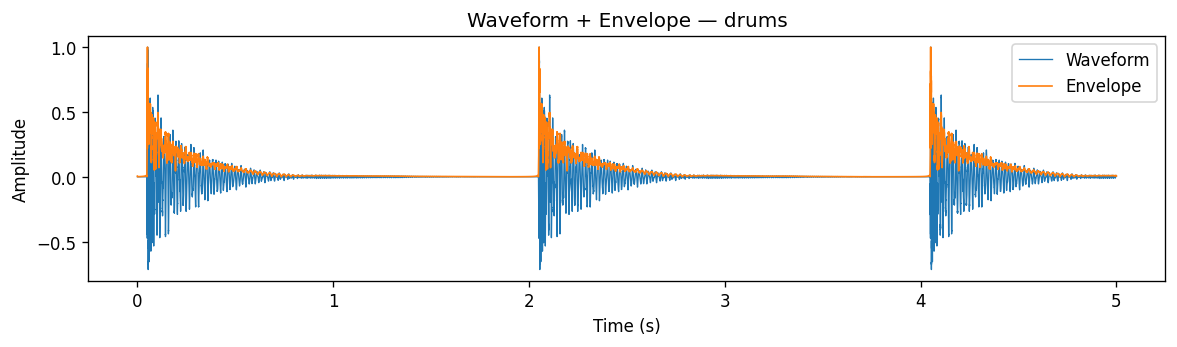

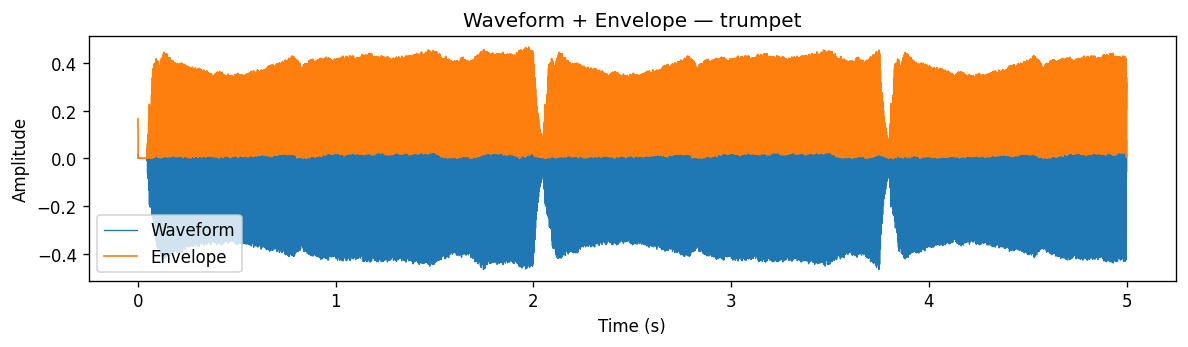

In [19]:
for name, y in waves.items():
    t = np.arange(len(y)) / SR
    env = utils.amplitude_envelope(y)
    plt.figure()
    plt.title(f"Waveform + Envelope — {name}")
    plt.plot(t, y, linewidth=0.8, label="Waveform")
    plt.plot(t, env * np.max(np.abs(y)), linewidth=1.0, label="Envelope")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.savefig(PLOTS / f"{name}_wave_env.png")
    plt.show()


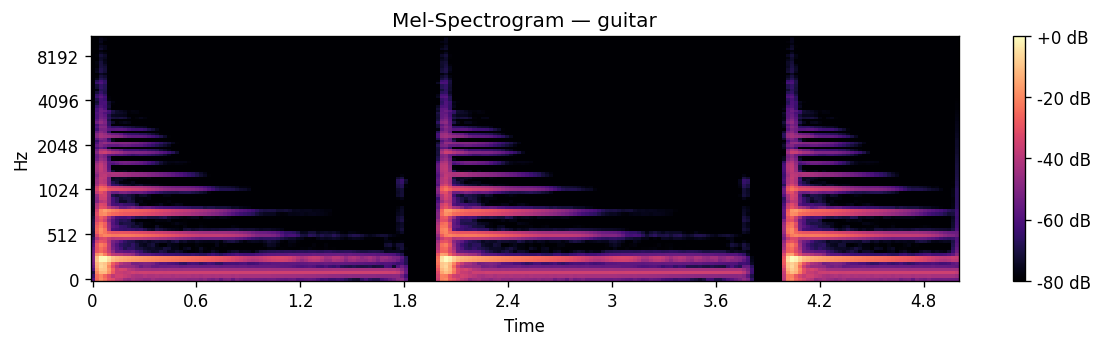

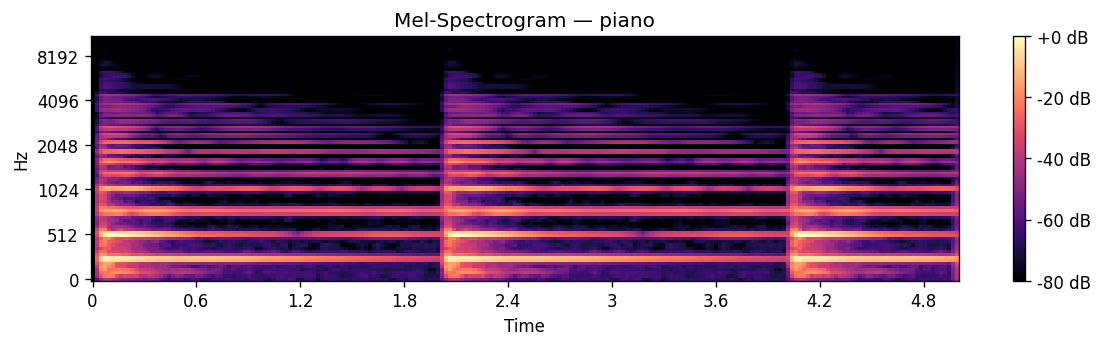

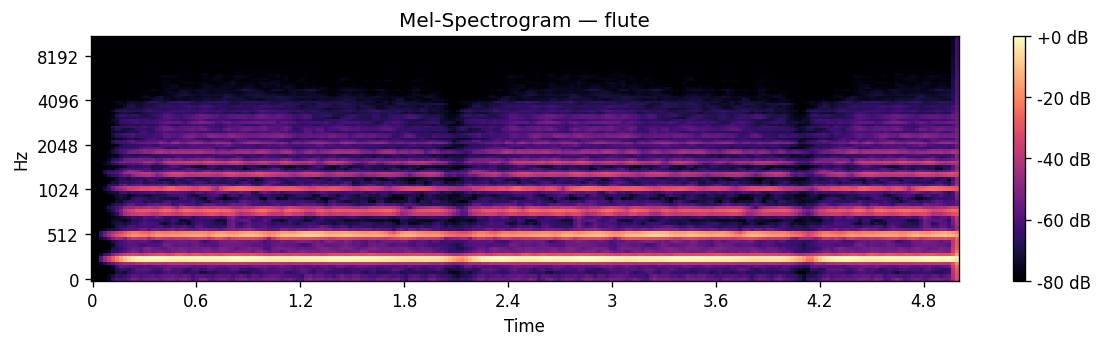

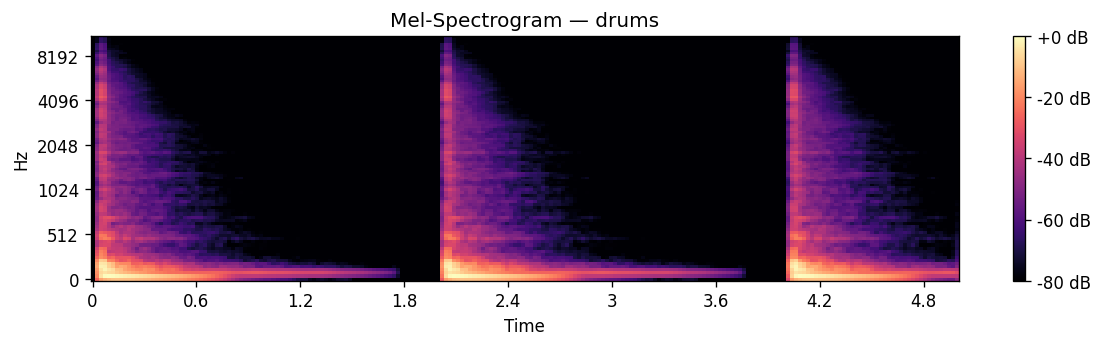

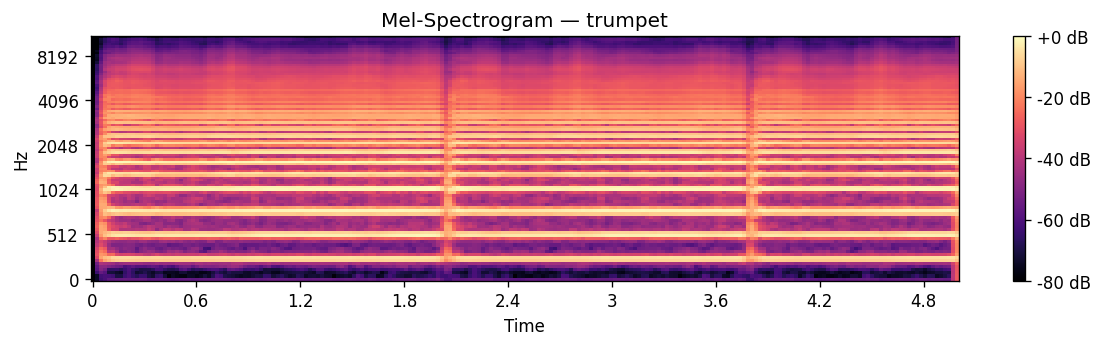

In [21]:
for name, y in waves.items():
    mel = librosa.feature.melspectrogram(y=y, sr=SR, n_mels=96)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    plt.figure()
    plt.title(f"Mel-Spectrogram — {name}")
    librosa.display.specshow(mel_db, sr=SR, x_axis="time", y_axis="mel")
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.savefig(PLOTS / f"{name}_melspec.png")
    plt.show()


In [23]:
rows = []
for name, y in waves.items():
    env = utils.amplitude_envelope(y)
    attack_s = utils.estimate_attack_time(env)
    spec = utils.spectral_block(y)
    mfcc, chroma, tempo_est, onset_rate = utils.perceptual_block(y)
    hnr = utils.hnr_proxy(y)

    feats = {
        "instrument": name,
        "rms": utils.rms(y),
        "attack_time_s": attack_s,
        "hnr_proxy_db": hnr,
        "tempo_est_bpm": float(tempo_est),
        "onset_rate_s": float(onset_rate),
    }

    for k in ["centroid", "bandwidth", "rolloff", "flatness", "flux", "zcr", "contrast"]:
        feats.update(utils.summarize_matrix(k, spec[k]))

    for i in range(mfcc.shape[0]):
        feats[f"mfcc{i+1}_mean"] = float(np.mean(mfcc[i]))
        feats[f"mfcc{i+1}_std"] = float(np.std(mfcc[i]))

    for i in range(12):
        feats[f"chroma{i}_mean"] = float(np.mean(chroma[i]))

    rows.append(feats)

df = pd.DataFrame(rows).set_index("instrument")
csv_path = OUTP / "features_summary.csv"
df.to_csv(csv_path)
df


/home/satan/git/audio_analysis/notebooks/utils.py:94: RuntimeWarning: invalid value encountered in log10
  return float(10 * np.log10((peak + 1e-9) / (noise + 1e-9)))
/tmp/ipykernel_106435/934785521.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "tempo_est_bpm": float(tempo_est),


,rms,attack_time_s,hnr_proxy_db,tempo_est_bpm,onset_rate_s,centroid_mean,centroid_std,centroid_median,bandwidth_mean,bandwidth_std,...,chroma2_mean,chroma3_mean,chroma4_mean,chroma5_mean,chroma6_mean,chroma7_mean,chroma8_mean,chroma9_mean,chroma10_mean,chroma11_mean
instrument,,,,,,,,,,,,,,,,,,,,,
guitar,0.092586,0.044807,NaN,30.046330,0.6,556.528988,557.402521,484.288977,1068.783124,513.140608,...,0.075275,0.049066,0.044360,0.052662,0.107889,0.209687,0.263836,0.307761,0.193013,0.289920
piano,0.100000,0.060136,NaN,30.046330,0.6,807.115484,211.608603,803.527365,840.346151,175.096681,...,0.019089,0.010028,0.023898,0.008466,0.037224,0.313816,0.081899,0.010165,0.025680,0.204487
flute,0.100000,0.268617,NaN,30.046330,3.8,549.765387,278.278799,515.928844,763.265015,259.430566,...,0.015720,0.003695,0.003980,0.003359,0.003333,0.007314,0.003963,0.004649,0.014020,0.246409
drums,0.099985,0.050839,NaN,30.046330,0.6,728.921332,859.336696,458.974708,1433.563945,785.207580,...,0.259480,0.177342,0.129516,0.227756,0.490231,0.627203,0.721901,0.538264,0.406383,0.436568
trumpet,0.100000,0.072698,NaN,99.384014,0.6,2297.899919,117.539644,2281.265667,1608.884124,73.515667,...,0.231772,0.129196,0.305525,0.089623,0.191100,0.855476,0.178357,0.172072,0.269679,0.210455


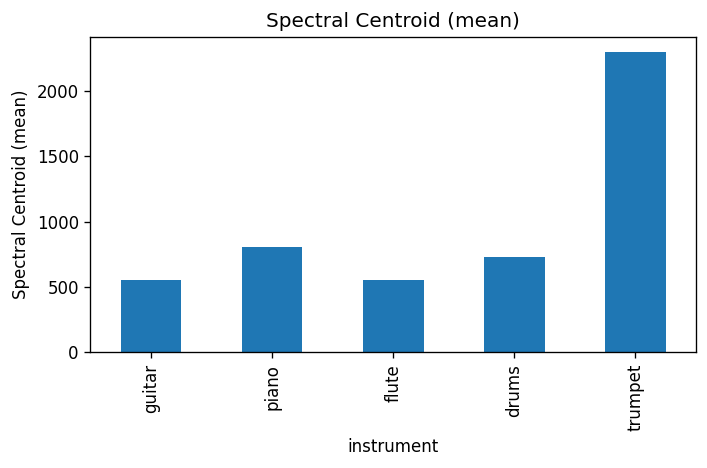

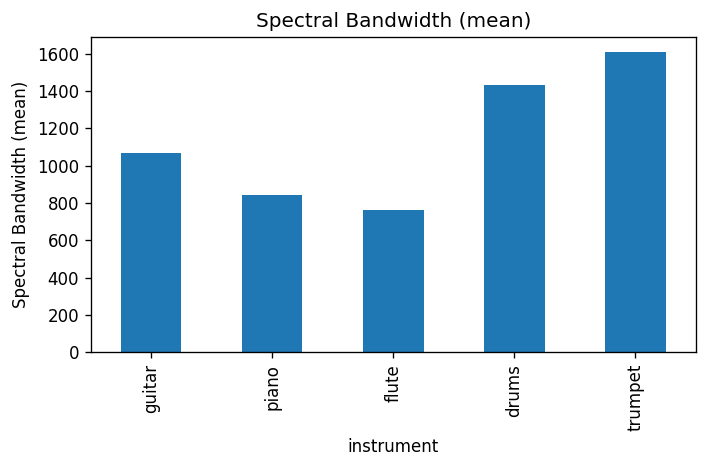

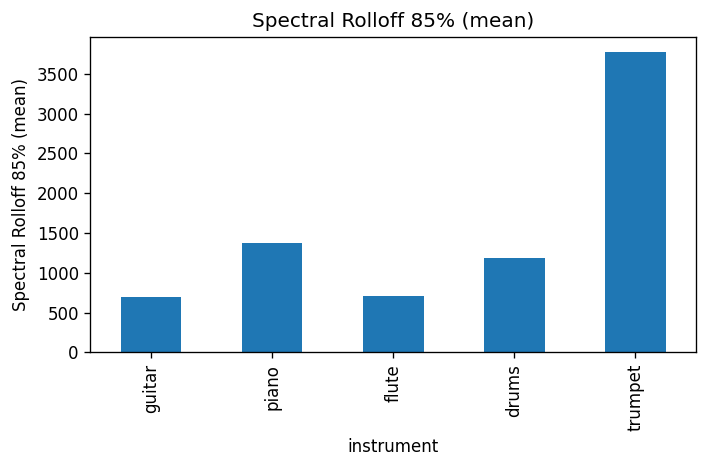

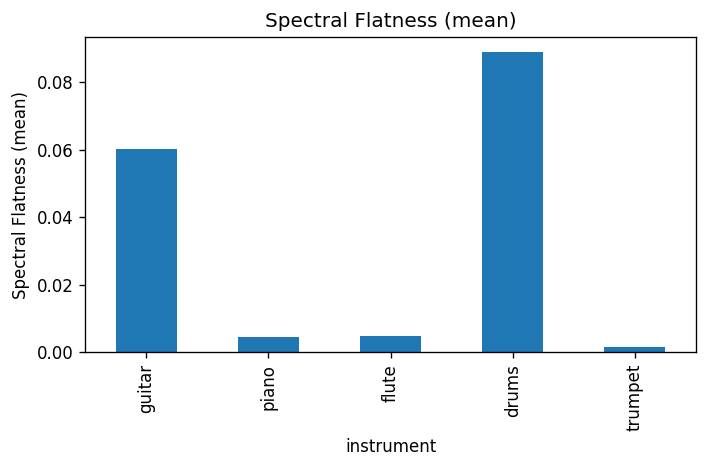

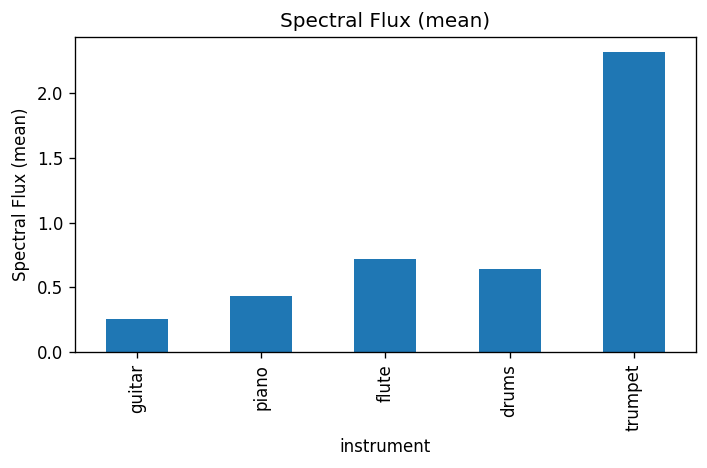

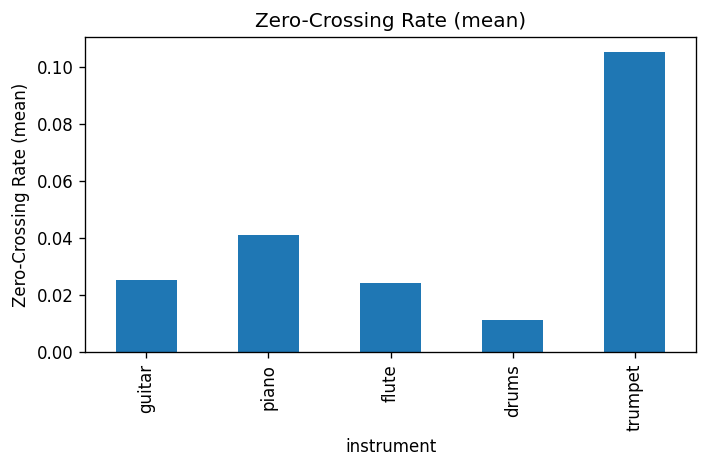

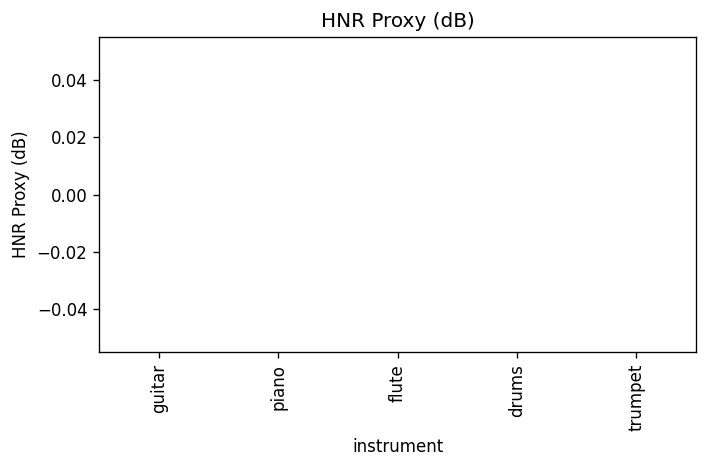

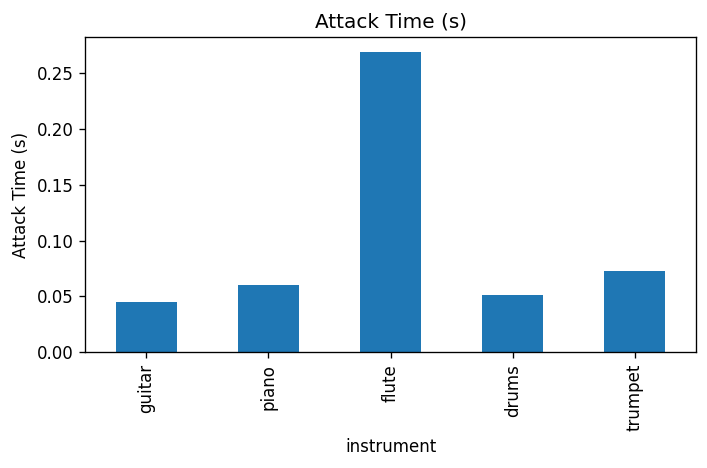

In [24]:
to_plot = [
    ("centroid_mean", "Spectral Centroid (mean)"),
    ("bandwidth_mean", "Spectral Bandwidth (mean)"),
    ("rolloff_mean", f"Spectral Rolloff {int(ROLLOFF_PCT*100)}% (mean)"),
    ("flatness_mean", "Spectral Flatness (mean)"),
    ("flux_mean", "Spectral Flux (mean)"),
    ("zcr_mean", "Zero-Crossing Rate (mean)"),
    ("hnr_proxy_db", "HNR Proxy (dB)"),
    ("attack_time_s", "Attack Time (s)"),
]

for key, label in to_plot:
    if key not in df.columns:
        continue
    plt.figure(figsize=(6, 4))
    df[key].plot(kind="bar")
    plt.ylabel(label)
    plt.title(label)
    plt.tight_layout()
    plt.savefig(PLOTS / f"compare_{key}.png")
    plt.show()


In [25]:
"""
### Interpretation checklist

- Centroid ↑ → brighter timbre
- Bandwidth / Rolloff ↑ → more high-frequency content
- Flatness ↑ → noisier / less harmonic
- HNR ↓ → less harmonic content
- Flux ↑ and Attack time ↓ → more percussive/transient character
- ZCR ↑ → more zero crossings, often brighter/noisier

Next:
Use `02_feature_groups.ipynb` to analyze correlations (PCA, clustering) and compare
feature groups (temporal, spectral, perceptual) for instrument separability.
"""


'\n### Interpretation checklist\n\n- Centroid ↑ → brighter timbre\n- Bandwidth / Rolloff ↑ → more high-frequency content\n- Flatness ↑ → noisier / less harmonic\n- HNR ↓ → less harmonic content\n- Flux ↑ and Attack time ↓ → more percussive/transient character\n- ZCR ↑ → more zero crossings, often brighter/noisier\n\nNext:\nUse `02_feature_groups.ipynb` to analyze correlations (PCA, clustering) and compare\nfeature groups (temporal, spectral, perceptual) for instrument separability.\n'